In [1]:
import os

os.environ['KAGGLE_USERNAME'] = 'username'
os.environ['KAGGLE_KEY'] = 'key'

!kaggle datasets download asdasdasasdas/garbage-classification

 89% 73.0M/82.0M [00:03<00:00, 26.5MB/s]
100% 82.0M/82.0M [00:03<00:00, 26.7MB/s]


In [ ]:
!unzip garbage-classification.zip

In [3]:
classes2int = {
    'cardboard': 3,
    'glass': 1,
    'metal': 5,
    'paper': 2,
    'plastic': 4,
    'trash': 6
}

int2classes = { v:k for k,v in classes2int.items() }

classes = list(classes2int.keys())
data_path = 'garbage classification/Garbage classification'

In [4]:
import pandas as pd

load_df = lambda file: pd.read_csv(file, sep=' ', header=None, names=['file', 'class'])

template_file = 'one-indexed-files-notrash_{dataset}.txt'
test_df = load_df(template_file.format(dataset='test'))
train_df = load_df(template_file.format(dataset='train'))
val_df = load_df(template_file.format(dataset='val'))

In [5]:
test_df.head()

,file,class
0,paper70.jpg,2
1,paper380.jpg,2
2,cardboard31.jpg,3
3,glass12.jpg,1
4,paper169.jpg,2


In [6]:
data_dir = 'data'

def create_necessary_dirs():
    os.makedirs(data_dir, exist_ok=True)

    datasets = ['test', 'train', 'val']

    for dataset in datasets:
        os.makedirs(f'{data_dir}/{dataset}', exist_ok=True)
        for cls in classes:
            os.makedirs(f'{data_dir}/{dataset}/{cls}')

def move_files(df, dataset):
    get_original_path = lambda row: f'{data_path}/{int2classes[row["class"]]}/{row["file"]}'
    get_dest_path = lambda row: f'{data_dir}/{dataset}/{int2classes[row["class"]]}/{row["file"]}'
    df.apply(
        lambda row: os.rename(get_original_path(row), get_dest_path(row)),
        axis=1
    )

In [7]:
create_necessary_dirs()
move_files(train_df, 'train')
move_files(test_df, 'test')
move_files(val_df, 'val')

In [8]:
test_path = f'{data_dir}/test'
train_path = f'{data_dir}/train'
val_path = f'{data_dir}/val'

In [9]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt

from PIL import Image
from glob import glob

from tensorflow.keras import layers

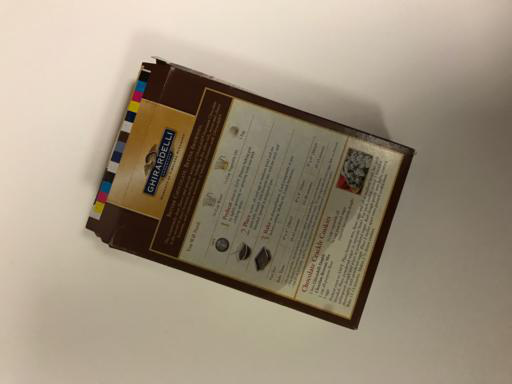

In [10]:
paper = glob(f'{test_path}/paper/*')[1]
Image.open(paper)

In [11]:
SEED = 42
BATCH_SIZE = 32
TARGET_HEIGHT = 300
TARGET_WIDTH = 300

In [12]:
from tensorflow.keras import preprocessing

# form the training and validation datasets

train_ds = preprocessing.image_dataset_from_directory(
    train_path,
    seed=SEED,
    image_size=(TARGET_HEIGHT, TARGET_WIDTH),
    batch_size=BATCH_SIZE
)

val_ds = preprocessing.image_dataset_from_directory(
    val_path,
    seed=SEED,
    image_size=(TARGET_HEIGHT, TARGET_WIDTH),
    batch_size=BATCH_SIZE
)

Found 1768 files belonging to 6 classes.
Found 328 files belonging to 6 classes.


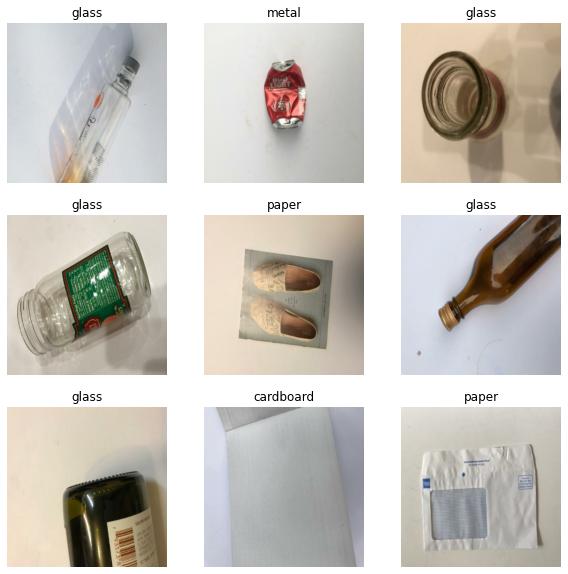

In [13]:
# explore some of the data of the different garbage types

plt.figure(figsize=(10, 10))
for imgs, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i].numpy().astype('uint8'))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis('off')

In [14]:
# set the buffer

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
import tensorflow.keras.layers.experimental.preprocessing as exp_preprocessing

norm_layer = exp_preprocessing.Rescaling(
    1./255, input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))
flip_layer = exp_preprocessing.RandomFlip(
    'horizontal', input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))
rotation_layer = exp_preprocessing.RandomRotation(0.1)
zoom_layer = exp_preprocessing.RandomZoom(0.1)

augment_layer = lambda in_layer: zoom_layer(rotation_layer(flip_layer(norm_layer(in_layer))))

In [16]:
num_classes = len(classes)

inception_V3 = tf.keras.applications.InceptionV3(
  weights="imagenet", include_top=False, input_shape=(TARGET_HEIGHT, TARGET_WIDTH, 3)
)

inception_V3.trainable = False

inputs = layers.Input(shape=(TARGET_HEIGHT, TARGET_WIDTH, 3))

outputs = augment_layer(inputs)
outputs = inception_V3(outputs)
outputs = layers.GlobalAveragePooling2D()(outputs)
outputs = layers.Dropout(0.2)(outputs)
outputs = layers.Dense(64, activation='relu')(outputs)
outputs = layers.Dense(num_classes, activation="softmax")(outputs)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

opt = tf.keras.optimizers.Adam(1e-4)

model.compile(
  optimizer=opt,
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=["accuracy"]
)

87916544/87910968 [==============================] - 1s 0us/step


In [17]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
rescaling (Rescaling)        (None, 300, 300, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 300, 300, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 300, 300, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 300, 300, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)             

In [18]:
# training

epochs = 200

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/200
56/56 [==============================] - 11s 196ms/step - loss: 1.6896 - accuracy: 0.3818 - val_loss: 1.5629 - val_accuracy: 0.5976
Epoch 2/200
56/56 [==============================] - 9s 152ms/step - loss: 1.5253 - accuracy: 0.6012 - val_loss: 1.4309 - val_accuracy: 0.7226
Epoch 3/200
56/56 [==============================] - 9s 154ms/step - loss: 1.4310 - accuracy: 0.6770 - val_loss: 1.3643 - val_accuracy: 0.7713
Epoch 4/200
56/56 [==============================] - 9s 156ms/step - loss: 1.3720 - accuracy: 0.7262 - val_loss: 1.3244 - val_accuracy: 0.7927
Epoch 5/200
56/56 [==============================] - 9s 157ms/step - loss: 1.3409 - accuracy: 0.7528 - val_loss: 1.2999 - val_accuracy: 0.8018
Epoch 6/200
56/56 [==============================] - 9s 159ms/step - loss: 1.3174 - accuracy: 0.7630 - val_loss: 1.2817 - val_accuracy: 0.8140
Epoch 7/200
56/56 [==============================] - 9s 161ms/step - loss: 1.3030 - accuracy: 0.7851 - val_loss: 1.2781 - val_accuracy: 0.801

In [19]:
test_ds = preprocessing.image_dataset_from_directory(
    test_path,
    image_size=(TARGET_HEIGHT, TARGET_WIDTH),
    batch_size=BATCH_SIZE
)

test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

model.evaluate(test_ds)

Found 431 files belonging to 6 classes.
14/14 [==============================] - 2s 165ms/step - loss: 1.1862 - accuracy: 0.8770


[1.186154842376709, 0.8770301342010498]

In [21]:
!pip install -q pyyaml h5py  # Required to save models in HDF5 format

!mkdir garbage_classification_model
model.save('garbage_classification_model/model')
model.save('garbage_classification_model/model.h5')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: garbage_classification_model/model/assets
